In [1]:
# Copyright 2018 Esref Ozdemir
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feature Selection (class balancing via oversampling)
In this document, we will be using oversampling methods and analyze their effects on classification performance. Training set is already constructed using random undersampling to make it somewhat balanced. However, random undersampling is used only to balance 
the important (goal, corner, etc.) and null events. Moreover, since penalty is a very rarely occuring event, the ratio of

$$
\frac{non\_penalty}{penalty} \approx 2
$$

This may potentially lead to poor performance on penalty events. We will try to oversample the penalty events, or undersample other events to make the training set balanced. Then, we plot the confusion matrices, feature importances and the tree itself.

In [1]:
%matplotlib inline
import pickle
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
pd.set_option('compute.use_bottleneck', True)
pd.set_option('compute.use_numexpr', True)

import sklearn.tree as tree

with open('../data/event_names.pkl', 'rb') as f:
    event_names = pickle.load(f)
event_names

{-931: 'Home Penalty',
 -930: 'Away Penalty',
 -801: 'Home Goal',
 -800: 'Away Goal',
 -621: 'Home Freekick',
 -620: 'Away Freekick',
 -601: 'Home Corner',
 -600: 'Away Corner',
 -21: 'Home Possession',
 -20: 'Away Possession',
 0: 'Null',
 60: 'Corner',
 62: 'Freekick',
 80: 'Goal',
 93: 'Penalty'}

In [2]:
data = pd.read_csv('../data/train/all_train.csv')
data = data.dropna().reset_index(drop=True)
X = data.iloc[:, 1:].values
y = data['eventId'].values
display(data.tail())

print('ID\tName')
print('--\t----')
for id in np.unique(y):
    print('{}\t{}'.format(id, event_names[id]))

,eventId,awayAvgX,awayAvgY,awayConvexCenterX,awayConvexCenterY,awayConvexClosestDistance,awayConvexFarDistance,awayConvexMaxSpeed,awayConvexMaxX,awayConvexMaxY,...,playerConvexMaxX,playerConvexMaxY,playerConvexMinX,playerConvexMinY,playerDenseClusterDensity,playerSparseClusterDensity,playerVerticalLinearity,refSpeed,refX,refY
12014,93,87.213000,37.402000,86.942000,38.970000,8.698551,32.489624,1.066068,104.46,50.12,...,104.46,67.66,54.47,14.21,0.443863,0.244145,1.870907,1.087796,94.22,39.70
12015,93,85.298889,40.223333,82.678333,39.648333,10.445088,28.865484,1.289729,94.27,50.07,...,94.27,67.79,53.84,28.43,0.747506,0.259059,2.878966,1.590629,94.09,40.78
12016,93,85.406667,40.493333,82.731667,40.241667,10.990523,29.338070,1.410319,94.30,49.47,...,94.30,67.62,53.45,28.69,0.723578,0.280277,2.701213,0.849294,93.59,42.29
12017,93,86.380000,36.735556,86.384000,37.292000,2.767400,11.764888,0.530094,88.08,44.67,...,88.65,50.00,63.68,25.65,1.169960,0.386518,7.271095,1.604307,91.99,42.50
12018,93,30.573750,37.155000,33.766667,37.596667,11.014339,20.273208,2.953726,52.46,48.44,...,52.46,59.86,13.53,21.77,0.852795,0.241942,3.004451,0.871321,1.59,34.95


ID	Name
--	----
0	Null
60	Corner
62	Freekick
80	Goal
93	Penalty


In [3]:
from utils import plot_hbar_nameval, plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from IPython.display import Image, display

import pydotplus

def decision_tree_cv(X, y, depth=3, k=10, feature_names=None, class_names=None):
    label_ids = sorted(np.unique(y), key=abs)
    
    clf = tree.DecisionTreeClassifier(
        class_weight='balanced',
        max_depth=depth,
    )
    
    skf = KFold(n_splits=k, shuffle=True)
    skf.get_n_splits(X, y)
    
    cm_list = []
    importance_list = []
    tree_list = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        conf_mat = confusion_matrix(y_test, y_pred, labels=label_ids)
        fig, ax = plot_confusion_matrix(conf_mat, class_names, 'Prediction', 'Truth', normalize=True)
        cm_list.append(fig)
        
        fig, ax = plot_hbar_nameval(feature_names, clf.feature_importances_, 'Feature importances', max_bars=10)
        importance_list.append(fig)
        
        dot_data = tree.export_graphviz(
            clf,
            out_file=None,
            feature_names=feature_names,
            class_names=class_names,
            filled=True,
        )
        graph = pydotplus.graph_from_dot_data(dot_data)
        fig = Image(graph.create_png())
        tree_list.append(fig)
        
    return cm_list, importance_list, tree_list

## Imbalanced Dataset

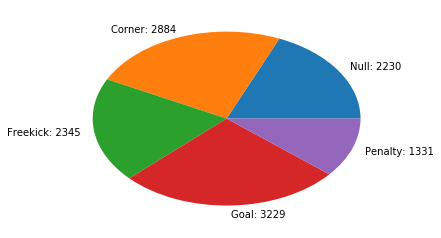

In [4]:
def pie_chart(event_counts):
    plt.pie(
        list(event_counts.values()),
        labels=['{}: {}'.format(event_names[key], val) for key, val in event_counts.items()]
    );

event_counts = dict(zip(*np.unique(y, return_counts=True)))
pie_chart(event_counts)

Before trying to select which features are the most useful ones, we need to fix the imbalance problem in our dataset: The methods we will use for feature selection uses the training data to build a model and select features according to predictive power. We try several methods to come up with a balanced training set.

See [Reference Articles](#Reference-Articles).

## SMOTE
SMOTE (Synthetic Minority Over-Sampling Technique) is an over-sampling technique that introduces small perturbations to **synthetic** examples along the direction of existing samples to reduce overfitting. See [original paper](http://www.jair.org/media/953/live-953-2037-jair.pdf) for detailed explanation of SMOTE.

### SMOTE Implementation
There is a SMOTE implementation in [imblearn](https://github.com/scikit-learn-contrib/imbalanced-learn) package for scikit-learn. However, there is not an option to apply SMOTE with arbitrary percentages (SMOTE-100, SMOTE-300, etc.); it simply balances all the classes. And also since SMOTE is not a hard to implement algorithm, we provide our own implementation. Our dataset sizes are not big (order of 10k). Hence, a simple Python implementation would be more than sufficien for our needs. See the original paper for reference algorithm.

In [5]:
from sklearn.neighbors import NearestNeighbors
from random import randint


def smote(samples, amount, k=5):
    """
    Apply SMOTE algorithm to samples and return a new samples
    array with synthetically created samples.
    
    Parameters
    ----------
    samples: (n_samples, n_features) samples array to be sent to
             SMOTE algorithm.
    amount: Percentage of newly created synthetic samples. (E.g.
            amount=100 would create as many synthetic examples
            as existing ones).
    k: Number of nearest neighbors in SMOTE algorithm.
    
    Returns
    -------
    out: ((1 + amount/100)*n_samples, n_features) samples array containing
         the original and the newly created synthetic examples.
         
    References
    ----------
    http://www.jair.org/media/953/live-953-2037-jair.pdf
    """
    samples = np.copy(samples)
    n_samples, n_features = samples.shape
    # handle amount < 100 case
    if amount < 100:
        num_samples = int(len(samples)*(amount/100))
        np.shuffle(samples)
        samples = samples[:num_samples, :]
        amount = 100
    amount = int(amount/100)
    synthetic = np.empty((n_samples*amount, n_features))
    # find k nearest neighbors of each point and store it in nnarray
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(samples)
    _, nnarray = nbrs.kneighbors(samples)
    nnarray = nnarray[:, 1:]  # get rid of self-nearest-neighbor.
    # create synthetic examples and store them in synthetic.
    for i, neighbors in enumerate(nnarray):
        for j in range(amount):
            chosen = neighbors[randint(0, k - 1)]
            diff = samples[chosen] - samples[i]
            gap = np.random.rand(n_features)
            synthetic[i*amount + j] = samples[i] + gap*diff
    out = np.vstack((samples, synthetic))
    
    return out

### Visualizing Synthetic SMOTE Examples

In [6]:
arr1 = np.random.normal(loc=5, scale=2.5, size=(50, 2))
arr2 = np.random.normal(loc=0, scale=2.5, size=(20, 2))

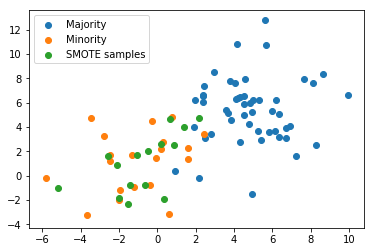

In [7]:
arr_smote = smote(arr2, 100)
plt.scatter(*arr1.T, label='Majority')
plt.scatter(*arr2.T, label='Minority')
plt.scatter(*arr_smote[25:, :].T, label='SMOTE samples')
plt.legend();

### SMOTE For Penalty Events
Number of penalties in our dataset is much fewer than other events. We use SMOTE algorithm with various synthetic example amounts to generate more penalty examples.

**We can't use nominal features in our current SMOTE implementation**

**TODO: Implement SMOTE-NC**

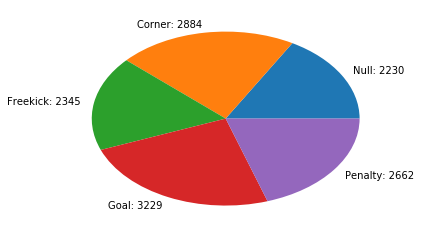

In [8]:
from sklearn.utils import shuffle

def smote_sampling(X, y):
    event = 93
    smote_amount = 100
    event_mask = y == event
    
    penalty_features = X[event_mask]
    synthetic_penalty = smote(penalty_features, smote_amount)
    n_synthetic = len(synthetic_penalty)

    # merge synthetic examples with original examples
    X_out = np.vstack((X[~event_mask], synthetic_penalty))
    y_out = np.concatenate((y[~event_mask], [event]*n_synthetic))

    return X_out, y_out


X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
mask = y != 0
X_out, y_out = smote_sampling(X, y)

event_counts = dict(zip(*np.unique(y_out, return_counts=True)))
pie_chart(event_counts)

## Classification Performance

### All Events

In [9]:
events = [0, 60, 62, 80, 93]
features = list(data.columns[1:])
cm_list_all, importance_list_all, tree_list_all = decision_tree_cv(
    X_out,
    y_out,
    depth=3,
    k=10,
    feature_names=features,
    class_names=[event_names[eid] for eid in events],
)

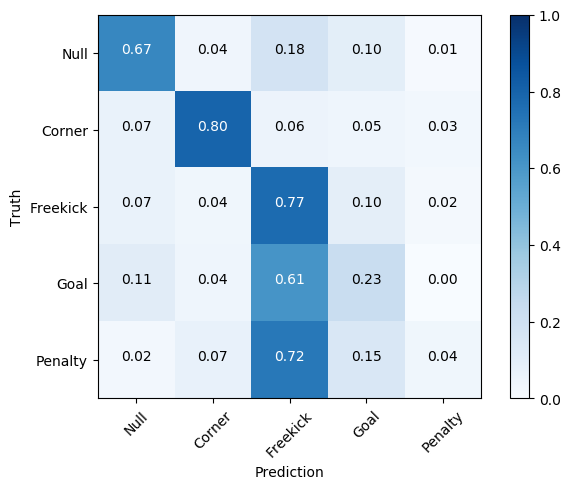

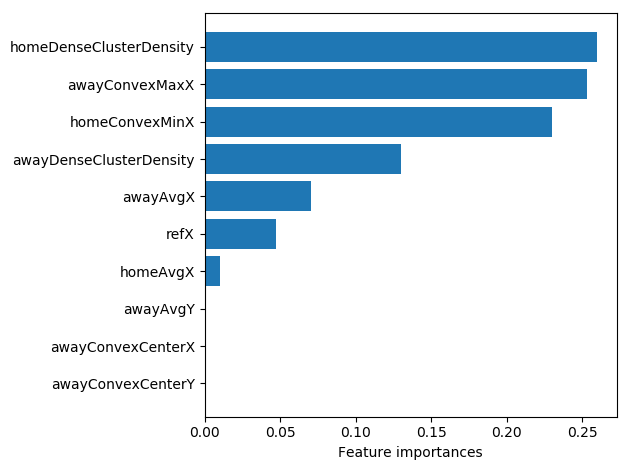

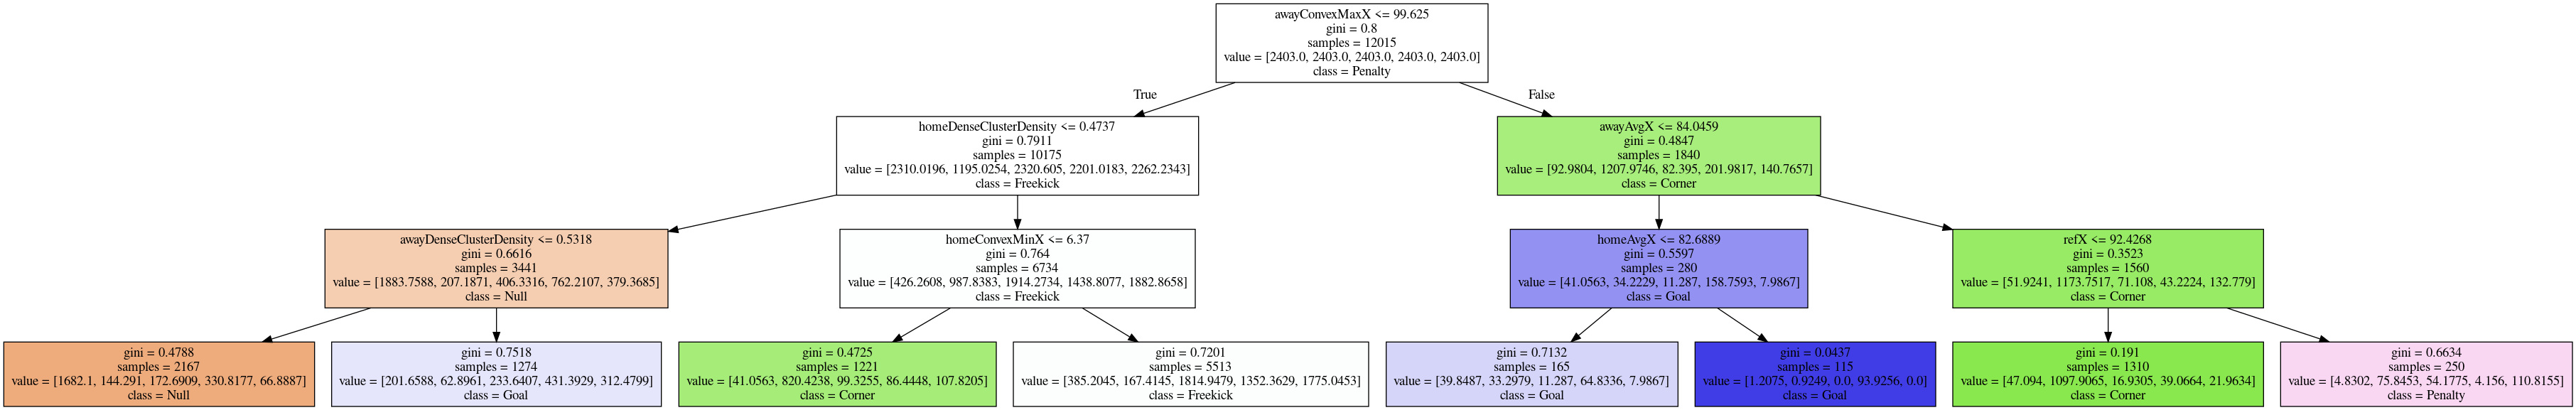

In [10]:
index = 5
display(cm_list_all[index])
display(importance_list_all[index])
display(tree_list_all[index])

### Null vs Penalty

In [11]:
mask = (y_out == 0) | (y_out == 93)
events = [0, 93]

features = list(data.columns[1:])
cm_list_pen, importance_list_pen, tree_list_pen = decision_tree_cv(
    X_out[mask],
    y_out[mask],
    depth=2,
    k=10,
    feature_names=features,
    class_names=[event_names[eid] for eid in events],
)

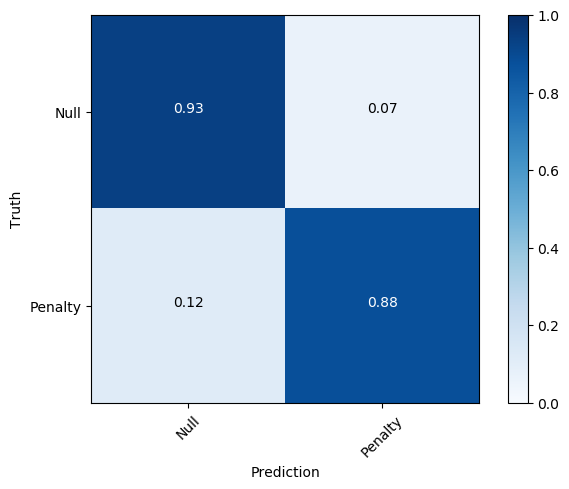

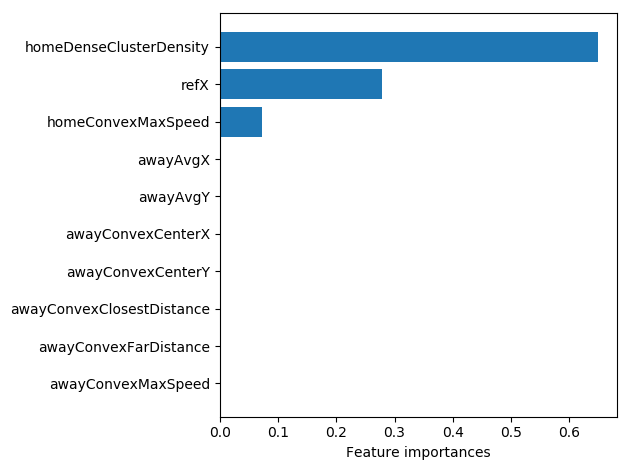

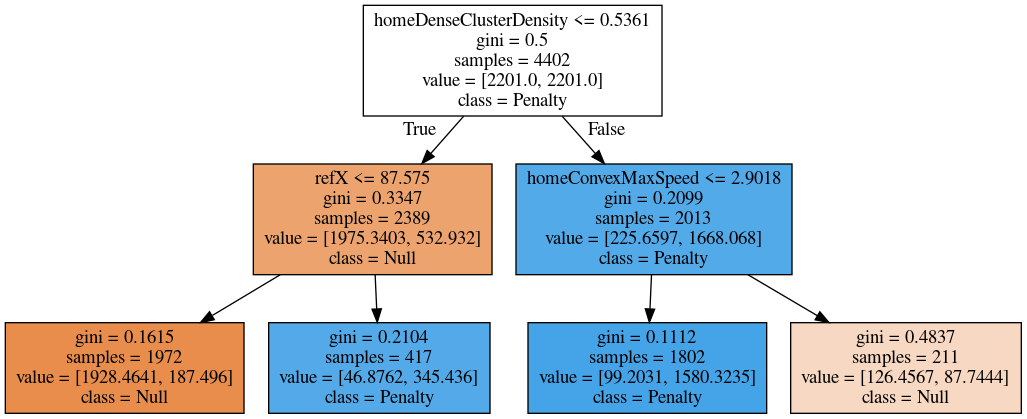

In [12]:
index = 0
display(cm_list_pen[index])
display(importance_list_pen[index])
display(tree_list_pen[index])

## Conclusion
Applying SMOTE doesn't seem to change the classification performance on a single decision tree. Both results are nearly identical to the ones obtained by using a single decision tree on non-oversampled dataset. Therefore, we don't plan to use oversampling techniques to balance the training set.

### Reference Articles

1. [SMOTE - Paper](http://www.jair.org/media/953/live-953-2037-jair.pdf)
2. [ADASYN - Paper](http://sci2s.ugr.es/keel/pdf/algorithm/congreso/2008-He-ieee.pdf)
3. [One Sided Selection](http://sci2s.ugr.es/keel/pdf/algorithm/congreso/kubat97addressing.pdf)
4. [Data Mining for Unbalanced Datasets - Paper](http://aetos.it.teithe.gr/~stoug/odep/papers/DATA%20MINING%20FOR%20IMBALANCED%20DATASETS:%20AN%20OVERVIEW.pdf)
5. [Machine Learning for Imbalanced Datasets - Paper](http://www.cs.colorado.edu/~mozer/Teaching/syllabi/6622/papers/Provost2000.pdf)
6. [Class Imbalance in Data Mining - Paper](https://arxiv.org/pdf/1305.1707.pdf)
7. [Cost Sensitive Learning vs Sampling](https://pdfs.semanticscholar.org/9908/404807bf6b63e05e5345f02bcb23cc739ebd.pdf)